# 모듈 불러오기

In [6]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

# 이미지 불러오기

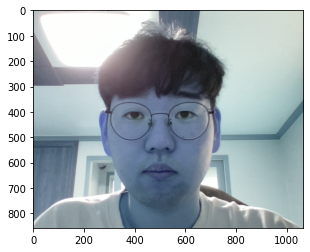

In [7]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_2.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

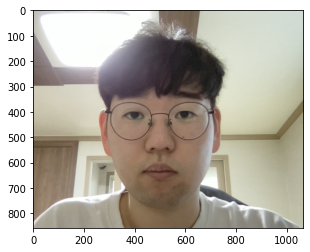

In [8]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 얼굴에 바운딩 박스 추출

rectangles[[(290, 333) (675, 718)]]


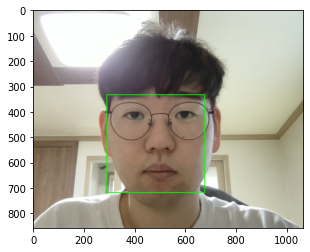

In [9]:
detector_hog = dlib.get_frontal_face_detector()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)


# 찾은 얼굴 영역 박스 리스트
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [10]:
#모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크

In [11]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


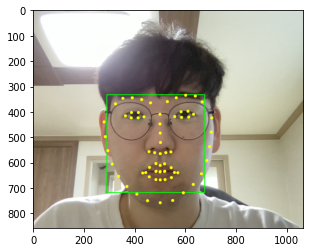

In [13]:
#랜드마크 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 6, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 스티커를 적용할 좌표 확인

In [14]:
#좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[8]) # 코의 index는 30 입니다
    x = landmark[8][0]
    y = landmark[8][1] - dlib_rect.height()//128
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(500, 758)
(x,y) : (500,755)
(w,h) : (386,386)


# 스티커 적용

In [15]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(386, 386, 3)


In [16]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (307,369)


In [17]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (307,369)


In [18]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 확인

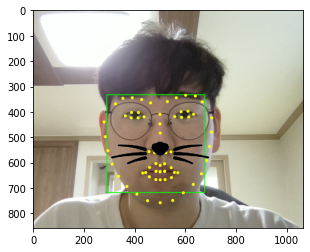

In [19]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 결과 출력

In [20]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

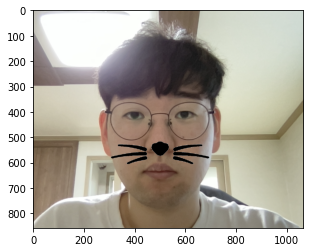

In [21]:
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 회고
-
이번 프로젝트를 하면서 처음 결과를 출력 했을 때는 당황스러웠다.

왜냐하면 왕관을 출력했을 때는 왕관 모양만 나오는데, 

고양이 수염을 출력하자 수염의 검은 부분만 사라지고 하얀 배경화면만 나왔기 때문이다.


- 
처음엔 사진의 배경을 없애기 위해 pillow를 이용하려고 해보기도 하고,

구글링을 해서 다른 코드들도 가져와보았지만 전혀 달라지는게 없었다.

결국 퍼실님께 도움을 요청했고, 알고보니 왕관 사진은 배경이 검은색이라서 np.where(img_sticker == 0)이었고,

내가 그대로 실행해버려서 고양이 수염의 검은색 부분만 사라진 것이었다.

np.where(img_sticker == 255)로 바꿔주자 원하던대로 나오게 되었다.


- 
여러사진을 실험해봤을 때

먼저 마스크를 낀 사진은 얼굴을 찾아내지 못했다.

코와 입 부분이 가려져서 못찾는 것 같았다.

얼굴사진보다 배경이 더 많은 경우도

얼굴을 잘 찾지 못하는 것 같았다.

이부분은 왜 못찾는지 모르겠다,,,

- 

이번 프로젝트를 하면서 아직도 코드를 보는게 낯설다는게 많이 느껴졌다.

얼굴각도를 틀고 얼굴 각도 만큼 고양이 수염사진도 틀어서 적용도 해보고 싶었지만

아직은 어디를 어떻게 건드려야 하는지 잘 모르겠고,

조금만 건드리면 오류만 났다. ㅜㅜ

조금 더 코드가 익숙해지면 다양한 시도를 해보고 싶다.